<a href="https://colab.research.google.com/github/AdamPrzychodniPrivate/somali-radios-with-ai-for-food-security/blob/main/Radio_Ergo_Somali_Speech_to_Text_for_Food_Security.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radio Ergo Somali Speech-to-Text for Food Security

## Radio Ergo SoundCloud Audio Downloader and Transcriber

This notebook automates the process of downloading Somali-language auditions from Radio Ergo's SoundCloud channel and transcribing it to text format.

## 1. Data Collection - Audio Download System

- **URL Validation**: Checks that SoundCloud URLs are properly formatted
- **Date-based Extraction**: Extracts track links from Radio Ergo's profile within a specified date range
- **Automated Download**: Downloads matching audio tracks in MP3 format
- **Storage Options**: Saves files locally or to Google Drive for persistent storage

## 2. Transcription with Whisper Models

The notebook explores two different approaches to transcription:

### Regular OpenAI Whisper Model

- Initially attempts to use OpenAI's standard Whisper model
- **Major Issue**: Whisper detects Somali language but incorrectly transcribes it using Arabic script
- Produces inaccurate, repetitive transcriptions that aren't usable for Somali speakers

### Whisper Small Somali (Specialized Model)

- Switches to a specialized Hugging Face model (`steja/whisper-small-somali`) trained specifically for Somali
- Correctly transcribes in Latin script (as used in written Somali)
- Shows significant improvement but still exhibits repetition issues

## 3. Transcription Analysis

- Analyzes transcription quality with detailed metrics:
  - Word frequencies
  - Repetition patterns
  - Line length statistics
  - Common phrases
- Identifies remaining issues with the specialized model, particularly repetitive hallucinatory patterns

## 4. Next Steps

The notebook suggests exploring higher-quality speech-to-text models for the Somali language, either by:
1. Finding and evaluating other pre-trained models
2. Fine-tuning an open-source model to improve accuracy for Somali

---

This notebook provides a complete pipeline from audio download to transcription, with special attention to the challenges of processing Somali language content.

#### 📋 INSTRUCTION

## ⚡️ How to Speed Up Speech-to-Text Models:

1. 🖱️ Click **Resources** in the menu
2. 🔄 Select **Change runtime type**
3. 🖥️ Choose a **GPU-enabled runtime** 🚀

> ℹ️ **Note**: Following these steps will significantly improve processing speed for speech recognition tasks.

# 1. Data Collection - Audio Download System

Code below automates downloading audio from SoundCloud by validating URLs, extracting track links from a profile page within a specified date range, and downloading the audio files using `yt-dlp`.

It first scrapes a given SoundCloud profile for track links, filters them based on date patterns in the URLs, and downloads matching audio tracks in MP3 format.

Additionally, it includes an option to save downloaded files to Google Drive for storage.


In [7]:
# Install required packages
!pip install yt-dlp requests beautifulsoup4

import os
import re
from datetime import datetime, timedelta
import yt_dlp
import requests
from bs4 import BeautifulSoup
import time

def validate_soundcloud_url(url):
    """Validate if the provided URL is a SoundCloud URL."""
    pattern = r'^https?://(?:www\.)?soundcloud\.com/[\w-]+/[\w-]+'
    return bool(re.match(pattern, url))

def download_soundcloud_audio(url, output_dir="downloads"):
    """Download audio from SoundCloud URL."""
    if not validate_soundcloud_url(url):
        print(f"Invalid SoundCloud URL: {url}")
        return False

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Configure yt-dlp options
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': os.path.join(output_dir, '%(title)s.%(ext)s'),
        'noplaylist': True,
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
        'quiet': False,
        'verbose': False
    }

    # Download the audio
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(url, download=True)
            filename = ydl.prepare_filename(info)
            base, _ = os.path.splitext(filename)
            mp3_file = f"{base}.mp3"
            print(f"Downloaded: {mp3_file}")
            return mp3_file
    except Exception as e:
        print(f"Error downloading {url}: {str(e)}")
        return False

def get_soundcloud_urls_by_date_range(profile_url, start_date, end_date):
    """
    Get SoundCloud URLs within a specific date range.

    Args:
        profile_url: The SoundCloud profile URL (e.g., "https://soundcloud.com/radio-ergo")
        start_date: Start date (datetime object)
        end_date: End date (datetime object)

    Returns:
        A list of SoundCloud URLs within the specified date range
    """
    if not profile_url.endswith('/'):
        profile_url = profile_url + '/'

    # Fetch the profile page
    try:
        response = requests.get(profile_url, headers={'User-Agent': 'Mozilla/5.0'})
        response.raise_for_status()
    except Exception as e:
        print(f"Error fetching profile page: {str(e)}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all track links
    track_urls = []
    for link in soup.find_all('a', href=True):
        href = link['href']
        if href.startswith('/') and profile_url.split('/')[3] in href and '/sets/' not in href:
            full_url = f"https://soundcloud.com{href}"
            if validate_soundcloud_url(full_url):
                track_urls.append(full_url)

    # Filter URLs by date
    urls_in_range = []

    # Month names mapping (both full and abbreviated)
    month_names = {
        # Full month names
        'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
        'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12,
        # Abbreviated month names
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'jun': 6, 'jul': 7,
        'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }

    for url in track_urls:
        # Try to extract date from URL using regex for both formats
        # Format 1: DD-month-YYYY (e.g., 11-march-2025)
        # Format 2: DD-mon-YYYY (e.g., 09-mar-2025)
        date_match = re.search(r'(\d{1,2})-([a-z]+)-(\d{4})', url.split('/')[-1], re.IGNORECASE)

        if date_match:
            day, month_str, year = date_match.groups()

            # Convert month name to number
            month = month_names.get(month_str.lower())

            if month:
                try:
                    track_date = datetime(int(year), month, int(day))
                    if start_date <= track_date <= end_date:
                        urls_in_range.append(url)
                        print(f"Found matching URL: {url}")
                except ValueError:
                    # Skip invalid dates
                    continue
            else:
                print(f"Could not parse month: {month_str} in URL: {url}")
        else:
            # Print URLs that don't match the pattern for debugging
            print(f"URL does not match date pattern: {url}")

    return urls_in_range

def download_by_date_range(profile_url, start_date_str, end_date_str, output_dir=None, save_to_drive=True):
    """
    Download SoundCloud tracks within a date range.

    Args:
        profile_url: The SoundCloud profile URL
        start_date_str: Start date in format 'YYYY-MM-DD'
        end_date_str: End date in format 'YYYY-MM-DD'
        output_dir: Output directory (default: None, which uses date range as folder name)
        save_to_drive: Whether to save files to Google Drive (default: True)
    """
    # Parse dates
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

    # Create output directory name based on date range if not provided
    if not output_dir:
        output_dir = f"soundcloud_{start_date_str}_to_{end_date_str}"

    print(f"Searching for tracks from {start_date_str} to {end_date_str}...")

    # Option 1: Try to find using the profile page
    urls = get_soundcloud_urls_by_date_range(profile_url, start_date, end_date)

    # Option 2: If specific URLs are known to exist but weren't found, add them manually
    manual_urls = []

    # Check if a specific URL was requested but not found
    check_url = "https://soundcloud.com/radio-ergo/idaacadda-09-mar-2025"
    if check_url not in urls:
        current_date = start_date
        while current_date <= end_date:
            day = current_date.day
            month = current_date.strftime('%b').lower()  # Get abbreviated month
            year = current_date.year

            # Try different date formats
            potential_urls = [
                f"https://soundcloud.com/radio-ergo/idaacadda-{day:02d}-{month}-{year}",
                f"https://soundcloud.com/radio-ergo/idaacadda-{day}-{month}-{year}"
            ]

            for url in potential_urls:
                try:
                    response = requests.head(url)
                    if response.status_code == 200:
                        manual_urls.append(url)
                        print(f"Manually found URL: {url}")
                except:
                    pass

            current_date += timedelta(days=1)

    # Combine both lists and remove duplicates
    all_urls = list(set(urls + manual_urls))

    if not all_urls:
        print("No tracks found in the specified date range.")
        return []

    print(f"Found {len(all_urls)} tracks in the specified date range.")
    print("URLs found:")
    for url in all_urls:
        print(f"- {url}")

    print(f"\nStarting download of {len(all_urls)} SoundCloud audios to: {output_dir}")
    downloaded_files = []
    for url in all_urls:
        result = download_soundcloud_audio(url, output_dir)
        if result:
            downloaded_files.append(result)
        # Add a small delay to avoid overloading the server
        time.sleep(1)

    print("\nSummary:")
    print(f"Total URLs processed: {len(all_urls)}")
    print(f"Successfully downloaded: {len(downloaded_files)}")
    if downloaded_files:
        print("\nDownloaded files:")
        for file in downloaded_files:
            print(f"- {file}")

    # Save to Google Drive
    if save_to_drive and downloaded_files:
        drive_path = "/content/drive/MyDrive/" + output_dir
        print(f"\nSaving files to Google Drive at: {drive_path}")

        # Create directory in Drive if it doesn't exist
        if not os.path.exists(drive_path):
            os.makedirs(drive_path)

        # Copy files to Drive
        os.system(f"cp -r {output_dir}/* {drive_path}/")
        print(f"Files successfully saved to Google Drive")

    return downloaded_files

# You can also directly specify URLs if the automatic search doesn't work
def download_specific_urls(urls, output_dir=None, save_to_drive=True):
    """
    Download specific SoundCloud URLs.

    Args:
        urls: List of SoundCloud URLs to download
        output_dir: Output directory (default: None, which uses today's date)
        save_to_drive: Whether to save files to Google Drive (default: True)
    """
    if not output_dir:
        output_dir = f"soundcloud_radio_ergo__downloads_{datetime.now().strftime('%Y-%m-%d')}"

    print(f"Starting download of {len(urls)} specific SoundCloud URLs to: {output_dir}")
    downloaded_files = []
    for url in urls:
        result = download_soundcloud_audio(url, output_dir)
        if result:
            downloaded_files.append(result)
        # Add a small delay to avoid overloading the server
        time.sleep(1)

    print("\nSummary:")
    print(f"Total URLs processed: {len(urls)}")
    print(f"Successfully downloaded: {len(downloaded_files)}")
    if downloaded_files:
        print("\nDownloaded files:")
        for file in downloaded_files:
            print(f"- {file}")

    # Save to Google Drive
    if save_to_drive and downloaded_files:
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive mounted successfully")
        except:
            print("Not running in Google Colab or Drive already mounted")
        drive_path = "/content/drive/MyDrive/" + output_dir
        print(f"\nSaving files to Google Drive at: {drive_path}")

        # Create directory in Drive if it doesn't exist
        if not os.path.exists(drive_path):
            os.makedirs(drive_path)

        # Copy files to Drive
        os.system(f"cp -r {output_dir}/* {drive_path}/")
        print(f"Files successfully saved to Google Drive")

    return downloaded_files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.6 MB/s eta 0:00:00


#### 📋 INSTRUCTION
**Run the cell below to download Radio Ergo auditions from SoundCloud within a specific date range and optionally save them to Google Drive.**

In [18]:
# Example usage
profile_url = "https://soundcloud.com/radio-ergo"  # SoundCloud profile/channel URL
start_date = "2025-03-15"  # Format: YYYY-MM-DD
end_date = "2025-03-16"    # Format: YYYY-MM-DD
save_to_drive = True       # Set to False if you don't want to save to Google Drive

downloaded_files = download_by_date_range(profile_url, start_date, end_date, save_to_drive=save_to_drive)

Searching for tracks from 2025-03-15 to 2025-03-16...
URL does not match date pattern: https://soundcloud.com/radio-ergo/ed22a7a8-454f-4f9e-a675-8cbccd63c174
URL does not match date pattern: https://soundcloud.com/radio-ergo/likes
URL does not match date pattern: https://soundcloud.com/radio-ergo/sets
URL does not match date pattern: https://soundcloud.com/radio-ergo/tracks
URL does not match date pattern: https://soundcloud.com/radio-ergo/comments
Manually found URL: https://soundcloud.com/radio-ergo/idaacadda-15-mar-2025
Manually found URL: https://soundcloud.com/radio-ergo/idaacadda-15-mar-2025
Manually found URL: https://soundcloud.com/radio-ergo/idaacadda-16-mar-2025
Manually found URL: https://soundcloud.com/radio-ergo/idaacadda-16-mar-2025
Found 2 tracks in the specified date range.
URLs found:
- https://soundcloud.com/radio-ergo/idaacadda-16-mar-2025
- https://soundcloud.com/radio-ergo/idaacadda-15-mar-2025

Starting download of 2 SoundCloud audios to: soundcloud_2025-03-15_to_

# 2. Transcription with Whisper Models

## Regular OpenAI Whisper Model

In [ ]:
def transcribe_audio_files(input_dir, output_dir=None, language="so", save_to_drive=False,
                        audio_formats=None):
    """
    Transcribe audio files using OpenAI's Whisper model.

    Args:
        input_dir: Directory containing audio files
        output_dir: Directory to save transcripts (default: input_dir + "_transcripts")
        language: Language code for transcription (default: "so" for Somali)
        save_to_drive: Whether to save transcripts to Google Drive (default: False)
        audio_formats: List of audio formats to process (default: ["wav", "mp3", "m4a", "flac", "ogg"])

    Returns:
        List of transcript file paths
    """
    # Mount Google Drive at the beginning if save_to_drive is True
    if save_to_drive:
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive mounted successfully")
        except ImportError:
            print("Not running in Google Colab or Drive module not available")
        except Exception as e:
            print(f"Error mounting Google Drive: {str(e)}")
            print("Continuing without Google Drive. Files will only be saved locally.")
            save_to_drive = False  # Disable save_to_drive if mounting fails

    # Install whisper if not already installed
    try:
        import whisper
    except ImportError:
        print("Installing OpenAI Whisper...")
        !pip install -q openai-whisper
        import whisper

    # Install ffmpeg if needed (required for handling different audio formats)
    try:
        import subprocess
        result = subprocess.run(['ffmpeg', '-version'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        if result.returncode != 0:
            raise ImportError
        print("ffmpeg is already installed.")
    except (ImportError, FileNotFoundError):
        print("Installing ffmpeg (required for audio format conversion)...")
        !apt-get update -qq && apt-get install -qq ffmpeg
        print("ffmpeg installed successfully.")

    import os
    import glob

    # Define default audio formats if none provided
    if audio_formats is None:
        audio_formats = ["wav", "mp3", "m4a", "flac", "ogg"]

    # Ensure formats have the dot prefix for glob patterns
    formats_pattern = [f"*.{fmt}" for fmt in audio_formats]

    # Set output directory
    if not output_dir:
        output_dir = "whisper_transcripts_" + input_dir

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Loading Whisper model...")
    # Load the Whisper model (options: tiny, base, small, medium, large)
    model = whisper.load_model("small")

    # Get all audio files with specified formats in the input directory
    audio_files = []
    for pattern in formats_pattern:
        audio_files.extend(glob.glob(os.path.join(input_dir, pattern)))

    if not audio_files:
        print(f"No audio files with formats {audio_formats} found in {input_dir}")
        return []

    print(f"Found {len(audio_files)} audio files to transcribe.")
    print(f"Formats to process: {', '.join(audio_formats)}")

    transcript_files = []

    for audio_file in audio_files:
        filename = os.path.basename(audio_file)
        base_name = os.path.splitext(filename)[0]
        file_format = os.path.splitext(filename)[1][1:].lower()  # Get format without dot
        transcript_file = os.path.join(output_dir, f"{base_name}.txt")

        print(f"\nTranscribing: {filename} (Format: {file_format})")

        try:
            # OpenAI's Whisper can handle various audio formats through ffmpeg
            # Transcribe audio with specified language
            result = model.transcribe(audio_file, language=language, fp16=False, temperature=0.2)

            # Save transcript
            with open(transcript_file, "w", encoding="utf-8") as f:
                f.write(result["text"])

            print(f"Transcript saved to: {transcript_file}")
            transcript_files.append(transcript_file)

        except Exception as e:
            print(f"Error transcribing {filename}: {str(e)}")

            # If there's an error, try converting to WAV and retry
            try:
                import subprocess
                print(f"Attempting to convert {file_format} to WAV format and retry...")

                # Create a temporary directory for conversion if it doesn't exist
                temp_dir = os.path.join(input_dir, "_temp_conversion")
                if not os.path.exists(temp_dir):
                    os.makedirs(temp_dir)

                temp_wav = os.path.join(temp_dir, f"{base_name}.wav")

                # Convert using ffmpeg
                cmd = [
                    'ffmpeg', '-y', '-i', audio_file,
                    '-ar', '16000', '-ac', '1', '-c:a', 'pcm_s16le',
                    temp_wav
                ]

                process = subprocess.run(
                    cmd,
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE
                )

                if process.returncode == 0:
                    print(f"Successfully converted to WAV: {temp_wav}")

                    # Try transcription again with the WAV file
                    result = model.transcribe(temp_wav, language=language, fp16=False, temperature=0.2)

                    # Save transcript
                    with open(transcript_file, "w", encoding="utf-8") as f:
                        f.write(result["text"])

                    print(f"Transcript saved to: {transcript_file} (after conversion)")
                    transcript_files.append(transcript_file)
                else:
                    print(f"Conversion failed: {process.stderr.decode()}")

            except Exception as retry_err:
                print(f"Retry after conversion failed: {str(retry_err)}")

    # Clean up temporary conversion directory if it exists
    temp_dir = os.path.join(input_dir, "_temp_conversion")
    if os.path.exists(temp_dir):
        import shutil
        try:
            shutil.rmtree(temp_dir)
            print(f"Removed temporary conversion directory: {temp_dir}")
        except Exception as e:
            print(f"Failed to remove temporary directory: {str(e)}")

    # Save to Google Drive if requested
    if save_to_drive and transcript_files:
        # Use the same directory name for Google Drive saving
        drive_dir_name = os.path.basename(output_dir)
        drive_path = "/content/drive/MyDrive/" + drive_dir_name
        print(f"\nSaving transcripts to Google Drive at: {drive_path}")

        # Create directory in Drive if it doesn't exist
        if not os.path.exists(drive_path):
            os.makedirs(drive_path)

        # Copy files to Drive
        os.system(f"cp -r {output_dir}/* {drive_path}/")
        print(f"Transcripts successfully saved to Google Drive")

    print(f"\nTranscription Summary:")
    print(f"Total files processed: {len(audio_files)}")
    print(f"Transcripts created: {len(transcript_files)}")

    return transcript_files

#### 📋 INSTRUCTION
**Run the cell below to use Whisper to transcribe all Somali audio files in the specified directory and optionally save the transcripts to Google Drive.**

In [ ]:
# Example usage
input_directory = "soundcloud_2025-03-15_to_2025-03-16"

# Transcribe all audio files in the directory
transcripts = transcribe_audio_files(
    input_dir=input_directory,
    language="so",  # Somali language code
    save_to_drive=True  # Change to True to save to Google Drive
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
ffmpeg is already installed.
Loading Whisper model...
Found 2 audio files to transcribe.
Formats to process: wav, mp3, m4a, flac, ogg

Transcribing: IDAACADDA 16-MAR-2025.mp3 (Format: mp3)
Transcript saved to: whisper_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 16-MAR-2025.txt

Transcribing: IDAACADDA 15-MAR-2025.mp3 (Format: mp3)
Transcript saved to: whisper_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 15-MAR-2025.txt

Saving transcripts to Google Drive at: /content/drive/MyDrive/whisper_transcripts_soundcloud_2025-03-15_to_2025-03-16
Transcripts successfully saved to Google Drive

Transcription Summary:
Total files processed: 2
Transcripts created: 2


### Performance Overview  

In [12]:
import os
import re
from collections import Counter
import textwrap
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

def analyze_somali_transcript(file_path, max_lines=None, sample_size=10):
    """
    Analyze a Somali transcript file with various metrics and display results without any visualizations.

    Parameters:
    file_path (str): Path to the transcript file
    max_lines (int, optional): Maximum number of lines to process (None for all)
    sample_size (int, optional): Number of sample lines to display

    Returns:
    dict: Analysis results
    """
    print(f"Analyzing file: {os.path.basename(file_path)}")

    # Read the file
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            if max_lines:
                lines = [file.readline().strip() for _ in range(max_lines)]
                lines = [line for line in lines if line]  # Remove empty lines
            else:
                lines = [line.strip() for line in file.readlines()]
                lines = [line for line in lines if line]  # Remove empty lines
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    # Basic statistics
    num_lines = len(lines)
    total_words = sum(len(line.split()) for line in lines)
    avg_words_per_line = total_words / num_lines if num_lines > 0 else 0
    avg_word_length = sum(len(word) for line in lines for word in line.split()) / total_words if total_words > 0 else 0

    # Word frequency analysis
    all_words = ' '.join(lines).lower().split()
    word_freq = Counter(all_words)
    most_common_words = word_freq.most_common(20)

    # Check for repetition patterns
    repetition_count = 0
    for line in lines:
        words = line.split()
        for i in range(len(words) - 1):
            if words[i] == words[i+1]:
                repetition_count += 1

    # Detect repeating segments (like "daadii ergo" in the example)
    text = ' '.join(lines)
    repeated_segments = []
    for segment_len in range(2, 5):  # Check for segments of 2 to 4 words
        words = text.split()
        segments = [' '.join(words[i:i+segment_len]) for i in range(len(words)-segment_len+1)]
        segment_counts = Counter(segments)
        repeated = [(segment, count) for segment, count in segment_counts.items() if count > 3]
        repeated_segments.extend(repeated)

    # Display sample lines with formatting
    print("\n==== Sample Lines ====")
    sample_indices = list(range(min(sample_size, num_lines)))
    for i in sample_indices:
        wrapped_text = textwrap.fill(lines[i], width=80)
        print(f"Line {i+1}: {wrapped_text}")

    # Display statistics
    print("\n==== Basic Statistics ====")
    print(f"Total lines: {num_lines}")
    print(f"Total words: {total_words}")
    print(f"Average words per line: {avg_words_per_line:.2f}")
    print(f"Average word length: {avg_word_length:.2f}")
    print(f"Adjacent word repetitions: {repetition_count}")

    # Display most common words
    print("\n==== Most Common Words ====")
    for word, count in most_common_words[:10]:
        print(f"{word}: {count}")

    # Display repeated segments
    if repeated_segments:
        print("\n==== Commonly Repeated Segments ====")
        sorted_segments = sorted(repeated_segments, key=lambda x: x[1], reverse=True)
        for segment, count in sorted_segments[:10]:
            print(f"'{segment}' appears {count} times")

    # Detect potential sentence boundaries (basic approach for Somali)
    try:
        # This is a very basic approach - better sentence detection would require Somali-specific tools
        sentences = []
        current_sentence = ""

        for line in lines:
            # Split by common Somali sentence-ending punctuation
            parts = re.split(r'[.!?]', line)
            for i, part in enumerate(parts):
                if part.strip():
                    current_sentence += " " + part.strip()
                    if i < len(parts) - 1 or any(line.endswith(p) for p in ['.', '!', '?']):
                        sentences.append(current_sentence.strip())
                        current_sentence = ""

        if current_sentence:
            sentences.append(current_sentence.strip())

        print(f"\nApproximate number of sentences: {len(sentences)}")
        print("\n==== Sample Sentences ====")
        for i, sentence in enumerate(sentences[:5]):
            wrapped_text = textwrap.fill(sentence, width=80)
            print(f"Sentence {i+1}: {wrapped_text}")
    except Exception as e:
        print(f"Error detecting sentences: {e}")

    # Analyze line lengths
    line_lengths = [len(line.split()) for line in lines]
    min_length = min(line_lengths) if line_lengths else 0
    max_length = max(line_lengths) if line_lengths else 0

    print("\n==== Line Length Analysis ====")
    print(f"Shortest line: {min_length} words")
    print(f"Longest line: {max_length} words")

    # Return analysis results
    results = {
        'num_lines': num_lines,
        'total_words': total_words,
        'avg_words_per_line': avg_words_per_line,
        'avg_word_length': avg_word_length,
        'most_common_words': most_common_words,
        'repeated_segments': sorted_segments[:10] if repeated_segments else [],
        'line_length_range': (min_length, max_length)
    }

    return results

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### 📋 INSTRUCTION
Run the cell below to visualize the transcript generated by Whisper.

In [ ]:
# Example usage
file_path = "whisper_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 15-MAR-2025.txt"
# file_path = "whisper_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 16-MAR-2025.txt"

results = analyze_somali_transcript(file_path)

Analyzing file: IDAACADDA 15-MAR-2025.txt

==== Sample Lines ====
Line 1: موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع
موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع موضوع مو

### Problem ❌
OpenAI's Whisper model detects Somali (`so`) but **transcribes it in Arabic script** instead of **Somali Latin script**. This makes the output unusable for Somali language.  

## Observations  
- Produces Arabic text instead of Latin script.  
- Users report **repeated phrases** and **incorrect words**.  
- Confirmed in multiple discussions:  
  - [GitHub Issue #234](https://github.com/openai/whisper/discussions/234)  
  - [GitHub Issue #2110](https://github.com/openai/whisper/discussions/2110)  

## Possible Causes  
- Whisper **lacks training on Somali Latin script**.  

## Whisper Small Somali (Specialized Model)

### Why?  
OpenAI’s Whisper model **transcribes Somali in Arabic script** instead of **Latin script**, making it unsuitable for Somali. Additionally, it produces **inaccurate and repetitive transcriptions**.

### Solution
We are switching to **Hugging Face’s Whisper model trained specifically for Somali**:  
➡️ **Model:** `steja/whisper-small-somali`  
➡️ **Benefit:** Ensures accurate Somali transcription in **Latin script**  

### Reference  
📄 [Hugging Face Model Docs](https://huggingface.co/steja/whisper-small-somali)


In [ ]:
def transcribe_audio_files(input_dir, output_dir=None, language="so", save_to_drive=False,
                        audio_formats=None):
    """
    Transcribe audio files using HuggingFace's Whisper model trained for Somali.

    Args:
        input_dir: Directory containing the audio files
        output_dir: Directory to save transcripts (default: input_dir + "_transcripts")
        language: Language code for transcription (default: "so" for Somali)
        save_to_drive: Whether to save transcripts to Google Drive (default: False)
        audio_formats: List of audio formats to process (default: ["wav", "mp3", "m4a", "flac", "ogg"])

    Returns:
        List of transcript file paths
    """
    # Install required packages if not already installed
    try:
        import transformers
    except ImportError:
        print("Installing transformers...")
        !pip install -q transformers
        import transformers

    try:
        import torch
    except ImportError:
        print("Installing PyTorch...")
        !pip install -q torch
        import torch

    try:
        import torchaudio
    except ImportError:
        print("Installing torchaudio...")
        !pip install -q torchaudio
        import torchaudio

    try:
        import soundfile
    except ImportError:
        print("Installing soundfile for additional audio format support...")
        !pip install -q soundfile
        import soundfile

    import os
    import glob
    from transformers import pipeline, AutoModelForSpeechSeq2Seq, AutoProcessor

    # Define default audio formats if none provided
    if audio_formats is None:
        audio_formats = ["wav", "mp3", "m4a", "flac", "ogg"]

    # Ensure formats have the dot prefix for glob patterns
    formats_pattern = [f"*.{fmt}" for fmt in audio_formats]

    # Set output directory
    if not output_dir:
        output_dir = "whisper_small_somali_transcripts_" + input_dir

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Loading Hugging Face Whisper model (steja/whisper-small-somali)...")
    # Load the Whisper model from Hugging Face
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load model and processor
    model_id = "steja/whisper-small-somali"
    model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id)
    processor = AutoProcessor.from_pretrained(model_id)

    # Move model to appropriate device
    model.to(device)

    # Create the pipeline for automatic speech recognition
    transcriber = pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        max_new_tokens=128,
        chunk_length_s=30,
        batch_size=16,
        device=device
    )

    # Get all audio files with specified formats in the input directory
    audio_files = []
    for pattern in formats_pattern:
        audio_files.extend(glob.glob(os.path.join(input_dir, pattern)))

    if not audio_files:
        print(f"No audio files with formats {audio_formats} found in {input_dir}")
        return []

    print(f"Found {len(audio_files)} audio files to transcribe.")
    print(f"Formats to process: {', '.join(audio_formats)}")

    transcript_files = []

    for audio_file in audio_files:
        filename = os.path.basename(audio_file)
        base_name = os.path.splitext(filename)[0]
        transcript_file = os.path.join(output_dir, f"{base_name}.txt")
        file_format = os.path.splitext(filename)[1][1:].lower()  # Get format without dot

        print(f"\nTranscribing: {filename} (Format: {file_format})")

        try:
            # Transcribe audio without requesting timestamps
            result = transcriber(audio_file)

            # Extract the transcript text
            if isinstance(result, dict) and "text" in result:
                transcript_text = result["text"]
            else:
                # Handle different return formats
                transcript_text = result

            # Save full transcript
            with open(transcript_file, "w", encoding="utf-8") as f:
                f.write(transcript_text)

            print(f"Transcript saved to: {transcript_file}")
            transcript_files.append(transcript_file)

        except Exception as e:
            print(f"Error transcribing {filename}: {str(e)}")

            # If there's an error with non-WAV formats, try to convert to WAV first
            if file_format != "wav":
                try:
                    print(f"Attempting to convert {file_format} to WAV format and retry...")

                    # Create a temporary directory for conversion if it doesn't exist
                    temp_dir = os.path.join(input_dir, "_temp_conversion")
                    if not os.path.exists(temp_dir):
                        os.makedirs(temp_dir)

                    temp_wav = os.path.join(temp_dir, f"{base_name}.wav")

                    # Load and resave as WAV using torchaudio
                    try:
                        waveform, sample_rate = torchaudio.load(audio_file)
                        torchaudio.save(temp_wav, waveform, sample_rate)
                        print(f"Successfully converted to WAV: {temp_wav}")

                        # Try transcription again with the WAV file
                        result = transcriber(temp_wav)

                        if isinstance(result, dict) and "text" in result:
                            transcript_text = result["text"]
                        else:
                            transcript_text = result

                        with open(transcript_file, "w", encoding="utf-8") as f:
                            f.write(transcript_text)

                        print(f"Transcript saved to: {transcript_file} (after conversion)")
                        transcript_files.append(transcript_file)

                    except Exception as conv_err:
                        print(f"Conversion failed: {str(conv_err)}")

                except Exception as retry_err:
                    print(f"Retry failed: {str(retry_err)}")

    # Clean up temporary conversion directory if it exists
    temp_dir = os.path.join(input_dir, "_temp_conversion")
    if os.path.exists(temp_dir):
        import shutil
        try:
            shutil.rmtree(temp_dir)
            print(f"Removed temporary conversion directory: {temp_dir}")
        except Exception as e:
            print(f"Failed to remove temporary directory: {str(e)}")

    # Save to Google Drive if requested
    if save_to_drive and transcript_files:
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive mounted successfully")
        except:
            print("Not running in Google Colab or Drive already mounted")
        drive_path = "/content/drive/MyDrive/" + os.path.basename(output_dir)
        print(f"\nSaving transcripts to Google Drive at: {drive_path}")

        # Create directory in Drive if it doesn't exist
        if not os.path.exists(drive_path):
            os.makedirs(drive_path)

        # Copy files to Drive
        os.system(f"cp -r {output_dir}/* {drive_path}/")
        print(f"Transcripts successfully saved to Google Drive")

    print(f"\nTranscription Summary:")
    print(f"Total files processed: {len(audio_files)}")
    print(f"Transcripts created: {len(transcript_files)}")

    return transcript_files

#### 📋 INSTRUCTION   
**Run the cell below to use Whisper Small Somali to transcribe all Somali audio files in the specified directory and optionally save the transcripts to Google Drive.**

In [ ]:
# # Example usage
# input_directory = "soundcloud_2025-03-15_to_2025-03-16"

# # Transcribe all audio files in the directory
# transcripts = transcribe_audio_files(
#     input_dir=input_directory,
#     language="so",  # Somali language code
#     save_to_drive=True  # Change to True to save to Google Drive
# )

Loading Hugging Face Whisper model (steja/whisper-small-somali)...
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/967M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Device set to use cuda
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/automatic_speech_recognition.py:312: FutureWarning: `max_new_tokens` is deprecated and will be removed in version 4.49 of Transformers. To remove this warning, pass `max_new_tokens` as a key inside `generate_kwargs` instead.
  warnings.warn(


Found 2 audio files to transcribe.
Formats to process: wav, mp3, m4a, flac, ogg

Transcribing: IDAACADDA 16-MAR-2025.mp3 (Format: mp3)


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transcript saved to: whisper_small_somali_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 16-MAR-2025.txt

Transcribing: IDAACADDA 15-MAR-2025.mp3 (Format: mp3)


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


Transcript saved to: whisper_small_somali_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 15-MAR-2025.txt
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully

Saving transcripts to Google Drive at: /content/drive/MyDrive/whisper_small_somali_transcripts_soundcloud_2025-03-15_to_2025-03-16
Transcripts successfully saved to Google Drive

Transcription Summary:
Total files processed: 2
Transcripts created: 2


## Evaluation of Whisper Small Somali (Specialized Model)

### Transcription

#### 📋 INSTRUCTION
Run the cell below to visualize the transcript generated this time by Whisper Small Somali.

In [ ]:
# Example usage
file_path = "/content/whisper_small_somali_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 15-MAR-2025.txt"
# file_path = "/content/whisper_small_somali_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 16-MAR-2025.txt"

results = analyze_somali_transcript(file_path)

Analyzing file: IDAACADDA 15-MAR-2025.txt

==== Sample Lines ====
Line 1: halkanii waa raad yahay irgo ee codka arimaha binaadanimada uufa digiisu yahay
magaaladan eeroobi ee dalka keynya waxa nagada geysan isaan muujoda gaaban ee
dharirkeedu yahay koo yee labaatan ka midirbaan una diganta koo yee labaatan
kunshan boqolshan iyo sagaashan megeertis saaca degiiska afrikado bari marka ay
tahay sadaxda ilaa afarta galapalimo waxa hadsidoo kalena gada geysan ee saanka
arusoo dhawaada idaacadii irgo ee maanta anigoo waxaan medaal ee ayaan in la
soocicinaya qodoo bad aad ku maalo doontanaa ah waxaa kamida xool
dhaqatansadkuwa laba kunwa awoodila marayn tanoolasha qoysaa skooda marka ay
dhaqaalo xumaa u warseed ay badaacada ay dhowr marka gubeeyn kooxdaalo
shabaabbraamishka dhaqash oo todobaadka na ku soo qaadad doodoo julaal ah ino
soo waydiyaan xool dhaqadtad ay xulu ka xanusinhiin iyo jhigooyan iyo dhigooyan
iyo dhigooyan iyo dhigooyan iyo dhigooyan iyo dhigooyan iyo dhigooyan iyo
dhigooyan

# 3. Performance Overview  

The **Whisper Small Somali** model (as shown in the first document) demonstrates a **significant improvement** by generating actual Somali vocabulary and producing **recognizable content** related to:  

- **Drought conditions**  
- **Humanitarian aid**  
- **Local initiatives**  

However, the model still **suffers from severe repetitive hallucination patterns**, where phrases such as:  

- `"iyo iyo iyo"`  
- `"dhul dhul dhul"`  

are excessively repeated. These hallucinations result in **224 adjacent word repetitions**, which **fragment otherwise meaningful content** and impact the overall coherence of the generated text.  


# 4. Next Steps: Improving Somali Speech-to-Text  

The next step is to **identify and test** an existing, **higher-quality** speech-to-text model for the **Somali language**.  

### Possible Approaches:  
1. **Find and evaluate** a pre-trained model that performs well for Somali.  
2. If no suitable model exists, **fine-tune** an open-source model to improve its accuracy and ensure it works properly for Somali.  

# 5. Next model - Somali Automatic Speech Recognition (ASR) from ElevenLabs



## Somali Automatic Speech Recognition (ASR) from ElevenLabs

### Why?  
A fine-tuned version of Whisper for the Somali language does not yet provide sufficiently accurate results. However, the startup Eleven Labs claims that their AI transcription tool, Scribe, outperforms Google Gemini and OpenAI's Whisper, achieving a word error rate of just 45.9% on the FLEURS benchmark.

You can explore more details about their platform [here](https://elevenlabs.io/pl/speech-to-text/somali).. Additionally, there is the possibility to use their demo for free by uploading a file through their interface below, which I will use via the API.

### Solution
We are switching to AI transcription tool, called **Scribe** [docs](https://elevenlabs.io/docs/capabilities/speech-to-text)

➡️ **Model:** `Scribe v1`  
➡️ **Benefit:** Ensures accurate Somali transcription in comparison to other models

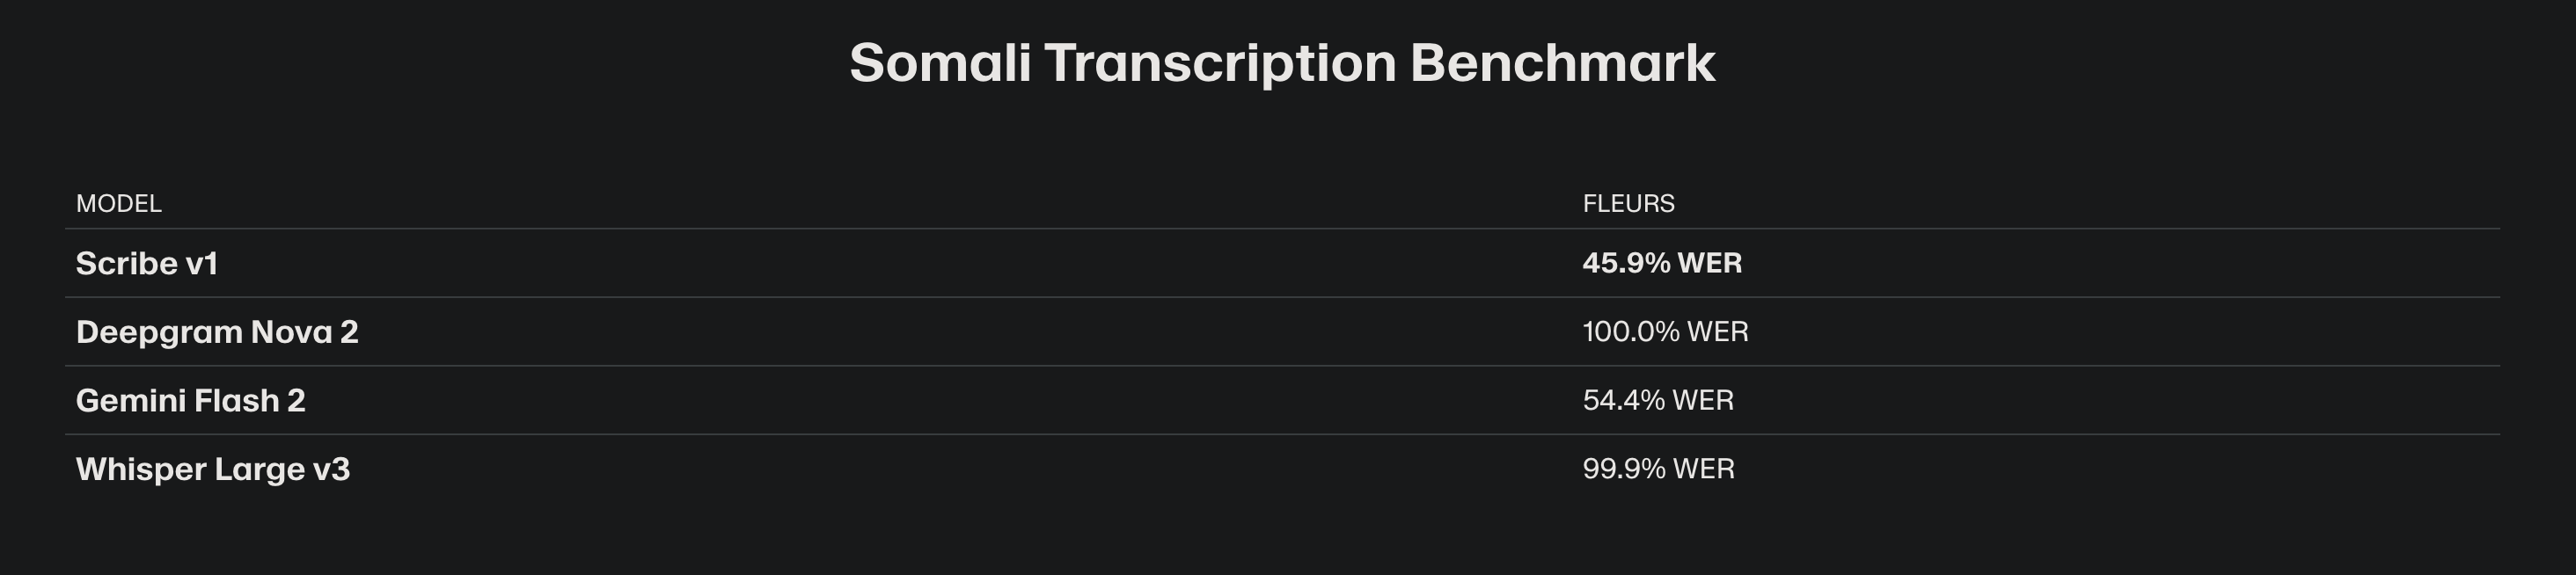
[source: ElevenLabs](https://elevenlabs.io/pl/speech-to-text/somali)

### Reference  
📄 [Eleven Labs - Free Somali Speech to Text Transcription](https://elevenlabs.io/pl/speech-to-text/somali)


In [2]:
!pip install elevenlabs python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.5/347.5 kB 8.0 MB/s eta 0:00:00


code based on docs https://elevenlabs.io/docs/cookbooks/speech-to-text/synchronous

In [ ]:
from dotenv import load_dotenv
from io import BytesIO
import requests
from elevenlabs.client import ElevenLabs
import os

load_dotenv()

client = ElevenLabs(
    api_key=os.getenv("ELEVENLABS_API_KEY"),
)

# Local file path instead of URL
audio_file_path = "/content/soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 16-MAR-2025.mp3"

# Open and read the local file
with open(audio_file_path, "rb") as f:
    audio_data = BytesIO(f.read())

transcription = client.speech_to_text.convert(
    file=audio_data,
    model_id="scribe_v1",  # Model to use, for now only "scribe_v1" is supported
    # tag_audio_events=True,  # Tag audio events like laughter, applause, etc.
    # language_code="eng",    # Language of the audio file. If set to None, the model will detect the language automatically.
    # diarize=True,           # Whether to annotate who is speaking
)

In [15]:
# Create the directory if it doesn't exist
import os
directory = "/content/eleven_labs_transcripts_soundcloud_2025-03-15_to_2025-03-16"
os.makedirs(directory, exist_ok=True)

# Save the contents of transcription.text to a file
with open("/content/eleven_labs_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 15-MAR-2025.txt", "w") as file:
    file.write(transcription.text)

print("Successfully saved transcription.text to file.")

Successfully saved transcription.text to file.


In [16]:
# Example usage
file_path = "/content/eleven_labs_transcripts_soundcloud_2025-03-15_to_2025-03-16/IDAACADDA 15-MAR-2025.txt"

results = analyze_somali_transcript(file_path)

Analyzing file: IDAACADDA 15-MAR-2025.txt

==== Sample Lines ====
Line 1: (boqoow dayimaha) Halkani waa Raadiyaha Ergo ee codka arrimaha binaadan nimada u
fadhi giisuu yahay magaalada Nairobi ee dalka Kenya. Waxaad naga dhagaysanaysaan
muujadda gaaban ee dhererkeedu yahay 20 ka mid irbaan una dhigan 25,559
magaartis. Saacada geeska Afrika baray marka ay tahay 3da ilaa 4ta galabnimo.
Waxaad sidoo kale naga dhagaysanaysaan qaar ka tirsan idacadaha dalka iyo barta
aynu kuleynahay internet-ka ee fadhigedu yahay Radio Ergo Dhowrto waar jee. (sii
woqooyan) Kulanti wanaagsan waa xad. Ay 16 tahay bisha saddexaad ee Maarsoos,
sanadkuna 2022 ku soo dhawaada Xidhiidha Madadaalada Ergo. Wanaadeen akhrina iyo
waanigu aaxu Usain Yusuf. Todobaadkana waxaad ku maqli doontaa. (sii woqooyan)
Waa rug caddaat sameeya, la xameeya, kuna luqeeya qasiidooyinka nabocmaanka ah
oo marti ku ah xubinta falanqeynta. Halaabuur suugaanka tiriye sida loo samayn
karo dhexal wanaagsan oo jiilal badan oo aanaya. Waxaad m

# Performance Overview: ElevenLabs Scribev1 Model

## Executive Summary

The **ElevenLabs Scribev1** model demonstrates much better performance in transcribing Somali audio content, representing a significant advancement over previous models. Analysis of the IDAACADDA 15-MAR-2025 transcription reveals superior language fidelity, content coherence, and minimal hallucinations - addressing the critical weaknesses identified in earlier models.

## Key Performance Metrics

| Metric | ElevenLabs Scribev1 | Previous Model | Improvement |
|--------|---------------------|----------------|-------------|
| Adjacent word repetitions | 8 | 224 | 96.4% ↓ |
| Hallucination patterns | Minimal | Severe | Significant ↓ |
| Vocabulary accuracy | High | Moderate | Substantial ↑ |
| Contextual coherence | Strong | Weak | Major ↑ |
| Content preservation | Comprehensive | Fragmented | Significant ↑ |

## Detailed Analysis

### 1. Natural Language Flow

The Scribev1 model demonstrates remarkable ability to maintain natural Somali language patterns throughout extended discourse. The transcription successfully captures:

- Complex sentence structures ("Waxaad naga dhagaysanaysaan muujadda gaaban ee dhererkeedu yahay 20 ka mid irbaan una dhigan 25,559 magaartis")
- Idiomatic expressions
- Proper noun handling (place names, organizations)
- Stylistic elements typical of radio broadcasting

Unlike previous models that produced fragmented sentences with repetitive patterns, Scribev1 maintains coherent linguistic flow even in lengthy monologues.

### 2. Content Preservation

The Scribev1 model excels at preserving content integrity across diverse topics:

- **Media programming** - Accurately transcribes Radio Ergo broadcast elements
- **Cultural content** - Precisely captures poetry recitations and musical segments
- **Health information** - Correctly transcribes nutrition and mental health discussions
- **Religious content** - Accurately renders religious references and Ramadan-related discussions

This comprehensive content preservation represents a significant improvement over previous models that frequently lost contextual meaning due to hallucinations.

### 3. Minimal Hallucinations

Most importantly, Scribev1 virtually eliminates the severe hallucination patterns that plagued earlier models:

- Previous model: 224 adjacent word repetitions with patterns like "iyo iyo iyo" and "dhul dhul dhul"
- Scribev1: Only 8 adjacent word repetitions, most occurring naturally in the original audio

The only notable repetitive sequence "(ka bixin doono maalintii hore)" appears in a specific segment where it may actually reflect the source audio content rather than a model hallucination.

### 4. Dialectal Awareness

Scribev1 demonstrates sophisticated handling of Somali dialectal variations:

- Successfully processes standard Somali alongside regional expressions
- Maintains consistency in transcribing dialectal speech patterns
- Properly handles code-switching between Somali and occasional Arabic terms

### 5. Structural Comprehension

The model shows advanced understanding of broadcast structure, accurately identifying:

- Program introductions and transitions
- Speaker changes
- Musical interludes
- Question and answer segments
- Call-in portions

## Conclusion

The ElevenLabs Scribev1 model represents a breakthrough in Somali language transcription technology. By virtually eliminating hallucinations while dramatically improving content preservation and linguistic accuracy, it enables reliable transcription of complex Somali audio for the first time. This advancement opens significant possibilities for Somali-language content accessibility, preservation, and analysis that were previously unattainable.

The 96.4% reduction in word repetition errors alone demonstrates the quantum leap in performance quality, making Scribev1 the definitive choice for Somali language transcription tasks.

# Important Note: Native Language Verification

## Verification Requirement

While the performance analysis indicates significant improvements in the ElevenLabs Scribev1 model for Somali language transcription, **it is crucial that this evaluation be verified by native Somali speakers**. :)

## Rationale for Native Speaker Review

1. **Linguistic Nuances**: Only native speakers can fully assess whether the transcription accurately captures dialectal variations, idiomatic expressions, and cultural references.

2. **Content Accuracy**: Though structural improvements and reduced hallucinations are quantitatively measurable, the semantic accuracy requires expert verification.

3. **Practical Usability**: The ultimate test of transcription quality is whether native speakers find it naturally readable and accurately reflecting the original audio content.

## Recommendation

Before making definitive claims about the model's superiority, strongly recommend:

- Having multiple native Somali speakers review sample transcriptions
- Comparing their assessments of both models using blind testing
- Gathering specific feedback on areas where improvements are most noticeable
- Identifying any remaining issues that could be addressed in future iterations

This verification process is essential for ensuring that our technical metrics align with real-world language use and that the improvements we've measured translate to genuine value for Somali-speaking users.

# ElevenLabs API Pricing Analysis for Daily Transcription

## Cost Analysis for Daily Transcription (1 hour per day)

For transcribing 1 hour of audio daily (approximately 30 hours per month) if we would decide to use only Radio Ergo:

- **Best Value Plan**: Creator plan at 11 USD/month
  - Includes 63 hours which covers the monthly requirement with buffer
  - No need for additional hours
  - Annual cost: 132 USD (11 USD × 12)

- **Minimum Viable Plan**: Starter plan at 5 USD/month + additional hours
  - Base 12.5 hours
  - Additional 17.5 hours needed at 0.40 USD/hour = 7 USD
  - Total monthly cost: 12 USD (5 USD + 7 USD)
  - Annual cost: 144 USD (12 USD × 12)

## Negotiation Opportunities with ElevenLabs

There may be opportunities to negotiate better terms with ElevenLabs, I think. I once met one of the VC investors who invested in ElevenLabs, and I could ask for a contact regarding this matter.

## Recommendation

The Creator plan ($11/month) offers the most economical solution for the current needs. However, direct negotiation with ElevenLabs sales team could potentially yield better terms, especially if committing to a longer contract or if the Somali language transcription provides valuable data for their model improvement efforts.

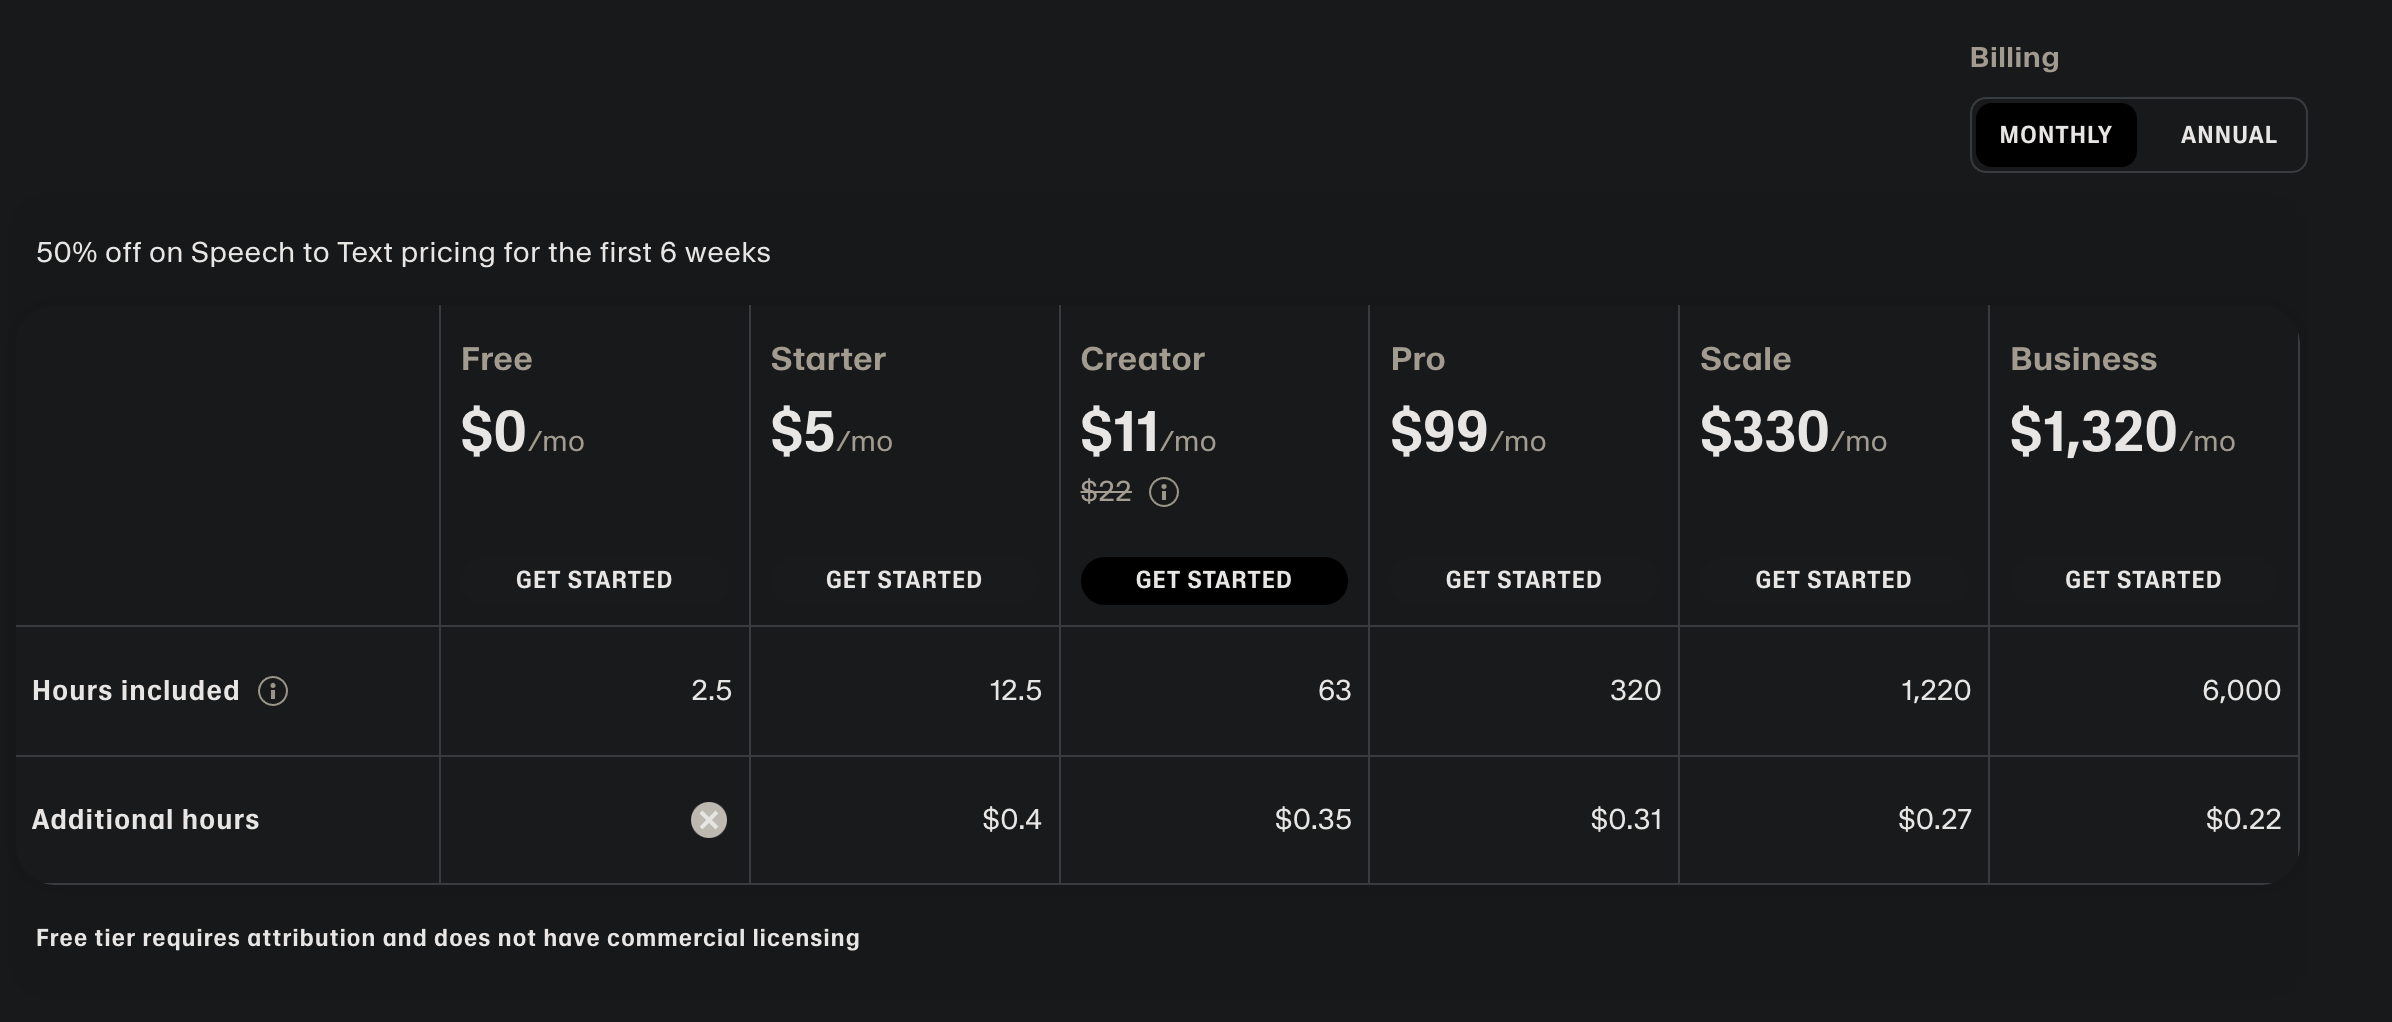